# Проект: вариант 4
## Задание 1
Представьте, что вы аналитик в компании, которая разрабатывает приложение для обработки и оформления фотографий в формате Stories (например, для дальнейшего экспорта в Instagram Stories). Был проведен A/B тест: тестовой группе предлагалась новая модель оплаты коллекций шаблонов, контрольной – старая механика. Ваша основная задача: проанализировать итоги эксперимента и решить, нужно ли выкатывать новую модель на остальных пользователей.

В ходе отчета обоснуйте выбор метрик, на которые вы обращаете внимание. Если различия есть, то объясните, с чем они могут быть связаны и являются ли значимыми.

Данные:

active_users – информация о пользователях, которые посещали приложение во время эксперимента. 

groups – разбивка пользователей на контрольную (А) и тестовую (В) группы. 

purchases – данные о транзакциях (оплатах) пользователей приложения во время эксперимента 
 

In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import norm, mannwhitneyu

from tqdm.auto import tqdm

plt.style.use('ggplot')

Загрузим данные, посмотрим из тип, размер датофреймов, количество пропусков и уникальных значений

In [101]:
active_users = pd.read_csv("https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/B4QnY5D5EtKa-A")
active_users.head()

,user_id,country,platform,sex
0,8029,Russia,ios,male
1,1735,Sweden,ios,male
2,7697,Russia,android,male
3,1421,Sweden,android,female
4,1704,Russia,ios,male


In [102]:
active_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   8341 non-null   int64 
 1   country   8341 non-null   object
 2   platform  8341 non-null   object
 3   sex       8341 non-null   object
dtypes: int64(1), object(3)
memory usage: 260.8+ KB


In [103]:
active_users.isna().sum()

user_id     0
country     0
platform    0
sex         0
dtype: int64

In [104]:
active_users.nunique()

user_id     8341
country        2
platform       2
sex            2
dtype: int64

In [105]:
groups = pd.read_csv("https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/jP_BAw_oxS3law")
groups.head()

,user_id,group
0,9149,B
1,9150,B
2,9151,A
3,9152,B
4,9153,B


In [106]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74576 entries, 0 to 74575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  74576 non-null  int64 
 1   group    74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [107]:
groups.isna().sum()

user_id    0
group      0
dtype: int64

In [108]:
groups.nunique()

user_id    74576
group          2
dtype: int64

In [109]:
purchases = pd.read_csv("https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/AmucCdboEaowhA")
purchases.head()

,user_id,revenue
0,4412,1000.0
1,9000,701.0
2,9001,700.0
3,9002,702.0
4,5790,1002.0


In [110]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  541 non-null    int64  
 1   revenue  541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [111]:
purchases.isna().sum()

user_id    0
revenue    0
dtype: int64

In [112]:
purchases.nunique()

user_id    541
revenue     98
dtype: int64

Посмотрим, нет ли аномалий и багов в оплатах пользователей (нулевые чеки и др.)

In [113]:
purchases.sort_values('revenue')

,user_id,revenue
521,9146,207.0
369,876,207.0
397,8201,208.0
330,1482,208.0
497,1796,208.0
...,...,...
224,591,3670.0
511,1227,3670.0
253,1606,3671.0
130,6483,3671.0


Объединим датафреймы purchases и groups по id пользователей

In [114]:
ab_users = groups.merge(purchases, how = 'outer', on = 'user_id')
ab_users

,user_id,group,revenue
0,9149,B,NaN
1,9150,B,NaN
2,9151,A,NaN
3,9152,B,NaN
4,9153,B,NaN
...,...,...,...
74571,1010,B,NaN
74572,7785,A,NaN
74573,1783,B,NaN
74574,1164,A,NaN


In [115]:
ab_users.user_id.nunique()  #проверим, всё ли правильно объединилось

74576

Объединим все данные в один датафрейм

In [116]:
all_users = active_users.merge(ab_users, how = 'outer', on = 'user_id')
all_users

,user_id,country,platform,sex,group,revenue
0,8029,Russia,ios,male,B,NaN
1,1735,Sweden,ios,male,B,NaN
2,7697,Russia,android,male,B,NaN
3,1421,Sweden,android,female,B,NaN
4,1704,Russia,ios,male,B,NaN
...,...,...,...,...,...,...
74571,75230,NaN,NaN,NaN,B,NaN
74572,75231,NaN,NaN,NaN,B,NaN
74573,75232,NaN,NaN,NaN,A,NaN
74574,75233,NaN,NaN,NaN,B,NaN


In [117]:
all_users.user_id.nunique()  #проверим, всё ли правильно объединилось

74576

### Наша задача: проанализировать итоги эксперимента и решить, нужно ли выкатывать новую модель на остальных пользователей.
Для начала сформулируем гипотезы для проверки:

Нулевая гипотеза (H0): Разницы между доходами с пользователей в тестовой и контрольной группе нет.

Альтернативная гипотеза (H1): Разница между средним доходом с пользователя в тестовой и контрольной группе есть.

In [118]:
#Посчитаем количество активных пользователей в тестовой и контрольной группе.
A_number_of_users = all_users.query('group == "A"').sex.count()
B_number_of_users  = all_users.query('group == "B"').sex.count()
print('Количество активных пользователей в группе А составляет', A_number_of_users, ', а число активных пользователей в группе В -', B_number_of_users)

Количество активных пользователей в группе А составляет 1538 , а число активных пользователей в группе В - 6803


In [119]:
#Посчитаем количество покупок в тестовой и контрольной группе.
A_number_of_buyers = all_users.query('group == "A"').revenue.dropna().count()
B_number_of_buyers  = all_users.query('group == "B"').revenue.dropna().count()
print('Количество покупок в группе А составляет', A_number_of_buyers, ', а покупки в группе В -', B_number_of_buyers)


Количество покупок в группе А составляет 107 , а покупки в группе В - 434


In [120]:
#Посчитаем конверсию из перехода на сайт в покупку в тестовой и контрольной группе.
A_CR = ((A_number_of_buyers / A_number_of_users)*100).round(2)
B_CR = ((B_number_of_buyers / B_number_of_users)*100).round(2)
print('Конверсия в покупку для группы А составляет', A_CR, '%, а конвесрия для группы В -', B_CR, '%')


Конверсия в покупку для группы А составляет 6.96 %, а конвесрия для группы В - 6.38 %


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


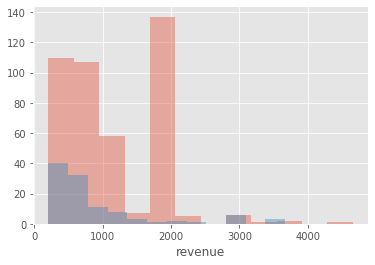

In [121]:
# Посмотрим на распределение метрики revenue по группам пользователей со старой и новой моделью оплаты.
sns.distplot(all_users.query('group == "B"').revenue.dropna(), kde=False) 
sns.distplot(all_users.query('group == "A"').revenue.dropna(), kde=False)

Можно заметить, что распределение в обеих группах отличается от нормального. 
Также в тестовой группе заметен резкий выброс. Попытаемся посмотреть более детально, с чем он связан.

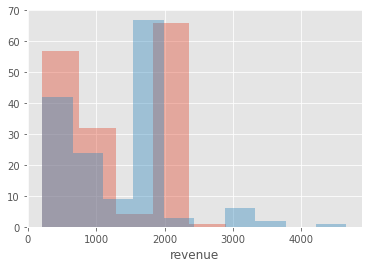

In [122]:
# Возможно, новый способ оплаты повлиял особенным образом на мужчин или женщин.
sns.distplot(all_users.query('group == "B" and sex == "male"').revenue.dropna(), kde=False) 
sns.distplot(all_users.query('group == "B" and sex == "female"').revenue.dropna(), kde=False) 

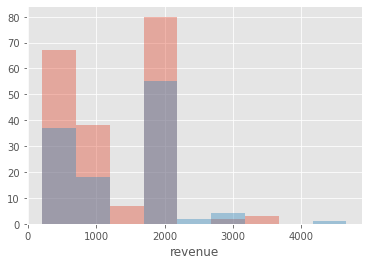

In [123]:
# Возможно, выброс связан со строной, где происходил эксперимент.
sns.distplot(all_users.query('group == "B" and country == "Russia"').revenue.dropna(), kde=False) 
sns.distplot(all_users.query('group == "B" and country == "Sweden"').revenue.dropna(), kde=False)

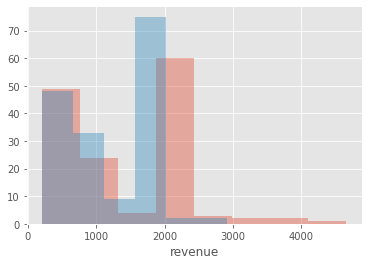

In [124]:
# Возможно, выброс связан с платформой, с которой происходила оплата.
sns.distplot(all_users.query('group == "B" and platform == "ios"').revenue.dropna(), kde=False) 
sns.distplot(all_users.query('group == "B" and platform == "android"').revenue.dropna(), kde=False)

Теперь изучим наши распределения. 
Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в тесте и в контроле (тест Шапиро-Уилка).

In [125]:
stats.shapiro(all_users[all_users['group'] == 'A']['revenue'].dropna().sample(100, random_state=17))

ShapiroResult(statistic=0.7083771228790283, pvalue=8.490562853485928e-13)

In [126]:
stats.shapiro(all_users[all_users['group'] == 'B']['revenue'].dropna().sample(100, random_state=17))

ShapiroResult(statistic=0.8842017650604248, pvalue=2.744953633282421e-07)

In [127]:
a_std = round(all_users.query('group == "A"').revenue.dropna().std(), 2)   #Стандартное отклонение суммы оплат в контроле
a_std

815.88

In [128]:
b_std = round(all_users.query('group == "B"').revenue.dropna().std(), 2)    #Стандартное отклонение суммы оплат в тесте
b_std

741.82

Здесь мы тестируем гипотезу о том, что распределения значимо не отличаются от нормального (H_0 p-value > 0.05).
Оба распределения отклоняются от нормального, так как р-уровень значимости меньше 0.05.

Для сравнения средних и при ненормальном распределении может быть использован t-тест, особенно на больших выборках и если в данных нет заметных выбросов.
Как вариант, можно преобразовать переменную, например, логарифмировать, чтобы сделать распределение более симметричным.
У нас же небольшой объем данных и присутствуют выбросы.

Если распределение признака отличается от нормального, можно использовать непараметрический аналог – U-критерий Манна-Уитни. 
Он переводит все данные в ранговую шкалу (ранжирует показатели температуры от 1 до последнего), после этого считает какой средний ранг оказался в первой группе и какой во второй. 
Этот критерий менее чувствителен к экстремальным отклонениям от нормальности и наличию выбросов, чем t-критерий Стьюдента.

Но Манн-Уитни, как и любой статистический оценщик, не очень приветлив к разному количеству наблюдений в выборках. 
Это сказывается в первую очередь на мощности критерия – чем сильнее дисбаланс, тем реже критерий будет обнаруживать реальную разницу (эффект).

Бутстрап позволяет строить доверительный интервал для любого параметра распределения, не применяя для этого аналитическую формулу.
Основное преимущество Бутстрапа — возможность проверять гипотезы для любых параметров распределения или модели: перцентилей, квантилей, децилей и т.п.
Бутстрап проверяет статистические гипотезы без опоры на определённое теоретическое распределение данных (в отличие от классических статистических критериев).
Бутстрап позволяет сделать оценку любого «сложного» параметра путём нахождения доверительных интервалов для него. А для проверки гипотез — путём вычисления их разницы.

Сравнив все методы и проанализировав наши данные, применим Бутстрап по медиане.

In [129]:
#Датафрейм контроль, значения
users_control = all_users.query('group == "A"').revenue.dropna()
#Датафрейм тест, значения
users_test = all_users.query('group == "B"').revenue.dropna()

In [130]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа (Медиана)

def get_bootstrap(
    users_control, # числовые значения первой выборки
    users_test, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(users_control), len(users_test)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = users_control.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = users_test.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # median() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    
     # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
           
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

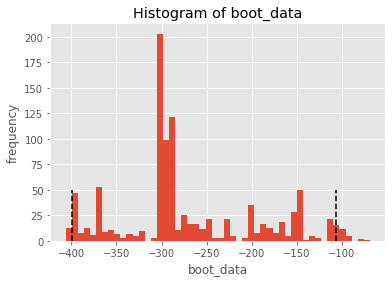

In [131]:
booted_data2 = get_bootstrap(users_control, users_test, boot_it = 1000) # в результате хранится разница двух распределений, ДИ и pvalue

In [132]:
booted_data2["p_value"]

0.0005555362442874312

In [133]:
booted_data2["ci"]

,0
0.025,-399.0
0.975,-107.0


## Выводы

Мы проверили количество пользователей в разных группах (в группе А 1538 человек, а в группе В - 6803) и количество покупателей в каждой из них (А составляет 107, а покупки в группе В - 434). Конверсия из посещения приложения в покупку для группы А составляет 6.96 %, а конвесрия для группы В - 6.38 %. Можно заметить, что в тестовой группе конверсия стала несколько меньше.

Однако, среднее среднее значение прибыли с человека в тесте больше, чем в контроле. Новую модель оплаты коллекций шаблонов можно раскатить на всех пользователей, так как среднее значение прибыли с одного пользователя статистически значимо изменилось. 

Также можно заметить резкий выброс метрики revenue для тестовой группы в диапазоне revenue от 1908.0 - 1912.0 (зарегестрирован всплеск количества оплат на эту сумму), в то время как в контрольной группе этого замечено не было, эффект наблюдался на всех платформах, независимо от пола покупателей и их страны. Возможно, для товаров из этого диапазона новая модель оплаты оказалась наиболе удобной и привлекательной.


# Задание 2
Одной из основных задач аналитика является не только построение моделей, но и создание дашбордов, 
которые позволяют отслеживать изменения метрик и принимать на их основе оптимальные решения. 
Ваш руководитель хочет узнать, как обстоят дела с использованием приложения и вовлечённостью пользователей, 
и очень просит спроектировать ему дашборд.

Предложите метрики, которые помогли бы ему отслеживать вовлеченность пользователей и принимать оптимальные решения. Какую основную информацию вы бы отразили на дашборде? На какие метрики стоит обратить внимание в первую очередь? Почему?

Для анализа работы приложения был разработан дашборд:
    
https://public.tableau.com/app/profile/anna4117/viz/StoryMakers/sheet8

Основное внимание было уделено прибыли с продаж и пользователям приложения. Как пользователи разного пола, из разных стран и с разных платформ совершали оплаты.